In [1]:
import os
import pyodbc
import pandas as pd
from arcgis.gis import GIS
import qgrid

In [2]:
#loading the estimates data 
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=DDAMWSQL16.sandag.org;'
                      'Database=estimates;'
                      'Trusted_Connection=yes;')

hhpop_2020 ="SELECT [mgra_id], [yr_id], [housing_type_id], [population]"\
                  "FROM [estimates].[est_2020_03].[dw_population]"\
                   "WHERE housing_type_id= 1"
                  
             
hhpop = pd.read_sql_query(hhpop_2020, conn)    

print(hhpop.head())

uniqueyr = hhpop['yr_id'].nunique()
print(uniqueyr)

      mgra_id  yr_id  housing_type_id  population
0  1400000101   2010                1          41
1  1400000102   2010                1           0
2  1400000201   2010                1          74
3  1400000202   2010                1           0
4  1400000301   2010                1         126
11


In [3]:
# loading the dim_mgra_denormalized table from demographic warehouse 
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=DDAMWSQL16.sandag.org;'
                      'Database=demographic_warehouse;'
                      'Trusted_Connection=yes;')

dim_mgra ="SELECT *"\
                  "FROM [demographic_warehouse].[dim].[mgra_denormalize]"\
                   "WHERE series= 14 " 
             
dim_mgra = pd.read_sql_query(dim_mgra, conn)    

dim_mgra.dtypes


mgra_id             int64
mgra                int64
series              int64
region             object
sra                object
tract              object
supervisorial      object
college            object
cpa                object
jurisdiction       object
zip                object
secondary          object
elementary         object
msa                object
sdcouncil          object
transit            object
unified            object
jurisdiction_id     int64
cpa_id              int64
taz                 int64
dtype: object

In [4]:
# setting up the query string for loading the mgra data from geodepot

mgra_query = """SELECT  [OBJECTID]
      ,[MGRA]
      ,[CT10]
      ,[CT10BG]
      ,[SRA]
      ,[MSA]
      ,[City]
      ,[ZIP]
      ,[Sphere]
      ,[CPA]
      ,[CPASG]
      ,[TAZ]
      ,[Council]
      ,[Super]
      ,[LUZ]
      ,[Elem]
      ,[Unif]
      ,[High]
      ,[Coll]
      ,[Transit]
      ,[Shape] """ + \
    ".STGeometryN(1).ToString()"  + "FROM [GeoDepot].[gis].[MGRA13PT]"

 # + geo_col + '.STGeometryN(1).ToString()'  
 #  ,[Shape]
   #-  ,[GDB_GEOMATTR_DATA]

In [5]:
# loading the mgra data from geodepot

conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=sql2014b8;'
                      'Database=GeoDepot;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()
             
mgra = pd.read_sql_query(mgra_query, conn)    

mgra.dtypes


OBJECTID     int64
MGRA         int64
CT10         int64
CT10BG       int64
SRA          int64
MSA          int64
City         int64
ZIP          int64
Sphere       int64
CPA          int64
CPASG        int64
TAZ          int64
Council      int64
Super        int64
LUZ          int64
Elem         int64
Unif         int64
High         int64
Coll         int64
Transit      int64
            object
dtype: object

In [6]:
# creating cross-walking between the age estimates table, dim_mgra table, and mgra geodepot file

mgra_shape= mgra.merge(dim_mgra, left_on='MGRA', right_on='mgra')
mgra_shape.shape[0]
mgra_shape.head()
estimates_mgra= mgra_shape.merge(hhpop, left_on= 'mgra_id', right_on= 'mgra_id')
print(estimates_mgra.shape[0])
estimates_mgra

# checking the number of rows in the final df remains intact during merge

print(estimates_mgra.shape[0]== uniqueyr*27316)


estimates_mgra.rename({"mgra": "MGRA"}, axis=1)

estimates_mgra.columns


300476
True


Index(['OBJECTID', 'MGRA', 'CT10', 'CT10BG', 'SRA', 'MSA', 'City', 'ZIP',
       'Sphere', 'CPA', 'CPASG', 'TAZ', 'Council', 'Super', 'LUZ', 'Elem',
       'Unif', 'High', 'Coll', 'Transit', '', 'mgra_id', 'mgra', 'series',
       'region', 'sra', 'tract', 'supervisorial', 'college', 'cpa',
       'jurisdiction', 'zip', 'secondary', 'elementary', 'msa', 'sdcouncil',
       'transit', 'unified', 'jurisdiction_id', 'cpa_id', 'taz', 'yr_id',
       'housing_type_id', 'population'],
      dtype='object')

In [7]:
# Loading GIS module from arcgis for visualizing estimates 

username = "Purva.Singh_SANDAG"
password = "Crisil1234"
gis = GIS("https://www.arcgis.com", username, password)



<Item title:"MGRA" type:Feature Layer Collection owner:SANDAG_Admin>
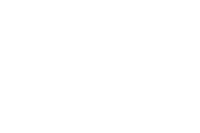

In [14]:
mgra13 = gis.content.search("MGRA", item_type="Feature Layer", )[4]
mgra_map = gis.map("San Diego", zoomlevel=16)
mgra13

In [9]:
mgra_map.add_layer(mgra13, {"field_name":"MGRA" })

In [10]:
mgra_map

MapView(layout=Layout(height='400px', width='100%'))

In [17]:
# viewing the attribute table for the mgra13 layer 
mgra_layer= mgra13.layers[0]

#sdf = pd.DataFrame.spatial.from_layer(mgra_layer)

sdf = mgra_layer.query().sdf

sdf.head()

,OBJECTID,MGRA,CT10,CT10BG,SRA,MSA,City,ZIP,Sphere,CPA,...,TAZ,Council,Super,LUZ,Elem,Unif,High,Coll,Transit,SHAPE
0,1,1,100,1001,1,0,14,92103,1442,1442,...,3331,3,4,95,0,30,0,4,1,"{""rings"": [[[-13045374.349833563, 3863379.4859..."
1,2,2,100,1001,1,0,14,92103,1442,1442,...,3331,3,4,95,0,30,0,4,1,"{""rings"": [[[-13044868.53026565, 3863126.96744..."
2,3,3,100,1001,1,0,14,92103,1442,1442,...,3358,3,4,95,0,30,0,4,1,"{""rings"": [[[-13044573.865921693, 3863107.2344..."
3,4,4,100,1001,1,0,14,92103,1442,1442,...,3358,3,4,95,0,30,0,4,1,"{""rings"": [[[-13044254.604501536, 3862633.8466..."
4,5,5,100,1001,1,0,14,92103,1442,1442,...,3358,3,4,95,0,30,0,4,1,"{""rings"": [[[-13044782.283246167, 3862848.1879..."


In [31]:
estimates_mgra= sdf.merge(estimates_mgra, left_on='MGRA', right_on='MGRA')

#estimates_mgra_16= estimates_mgra[estimates_mgra['yr_id']==2016]

sdf.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [32]:
cities = gis.content.search("Jurisdictions", item_type="Feature Layer", )[9]
cities_layer= cities.layers[0]
city_df = cities_layer.query().sdf
city_df.spatial.plot()

#estimates_mgra_16.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [ ]:
#renderer_type='u', # specify the unique value renderer using its notation 'u'
      #  col='MGRA')